In [1]:
from HARK.distributions import Bernoulli, Lognormal, MeanOneLogNormal, Normal
from HARK.model import Control, DBlock, RBlock

from HARK.simulation.monte_carlo import MonteCarloSimulator

import math

In [2]:
consumption_block = DBlock(
    **{
        "name": "consumption",
        "shocks": {
            "theta": (Normal, {"mu" : 0, "sigma": "TranShkStd"}),
        },
        "dynamics": {
            "y": lambda y, rho, theta: y * rho + theta,
            "R" : Control(["a", "y"]),
            "w": lambda a, R, y: R * a + math.e ** y,
            "c": Control("w"), # constraint c < w - debt_limit
            "a": lambda w, c: w - c,
        },
        "reward": {
            "u": lambda c, CRRA: c ** (1 - CRRA) / (1 - CRRA),
            "d": lambda a, R: - a * R 
        },
    }
)

In [3]:
calibration = {
    "DiscFac": 0.96,
    "CRRA": 2.0,
    "rho" : 0.95,
    "R": 1.03, # will get overridden
    "TranShkStd": 0.1,
    "debt_limit" : -1
}

In [7]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

def create_credit_model():
    """
    Create a directed graph representing the credit scoring model with
    different variable types and their relationships.
    """
    G = nx.DiGraph()
    
    # Define nodes with their attributes
    nodes = {
        # State variables (circles)
        'y': {'name': 'Income', 'type': 'state', 'system': 'borrower'},
        'w': {'name': 'Assets', 'type': 'state', 'system': 'borrower'},
        'a': {'name': 'Loan', 'type': 'state', 'system': 'borrower'},
        's': {'name': 'Credit Score', 'type': 'state', 'system': 'credit'},
        's_next': {'name': 'Updated Score', 'type': 'state', 'system': 'credit'},
        
        # Control variables (rectangles)
        'c': {'name': 'Consumption', 'type': 'control', 'system': 'borrower'},
        'r': {'name': 'Interest Rate', 'type': 'control', 'system': 'lender'},
        
        # Utility variables (diamonds)
        'u_b': {'name': 'Borrower Utility', 'type': 'utility', 'system': 'borrower'},
        'u_l': {'name': 'Lender Profit', 'type': 'utility', 'system': 'lender'},
        
        # Agents (circles)
        'B': {'name': 'Borrower', 'type': 'state', 'system': 'borrower'},
        'L': {'name': 'Lender', 'type': 'state', 'system': 'lender'},
    }
    
    # Add nodes to graph
    for node_id, attrs in nodes.items():
        G.add_node(node_id, **attrs)
    
    # Define edges representing relationships in the model
    edges = [
        ('B', 'c'),       # Borrower controls consumption
        ('y', 'w'),       # Income affects assets
        ('w', 'a'),       # Assets determine loan amount
        ('w', 'c'),       # Assets constrain consumption
        ('c', 'a'),       # Consumption affects loan amount
        ('c', 'u_b'),     # Consumption determines borrower utility
        ('a', 's'),       # Loan affects credit score
        ('y', 's'),       # Income affects credit score
        ('s', 's_next'),  # Credit score evolves over time
        ('w', 's_next'),  # Assets affect future credit score
        ('s', 'r'),       # Credit score affects interest rate
        ('L', 'r'),       # Lender sets interest rate
        ('a', 'r'),       # Loan amount affects interest rate
        ('r', 'u_l'),     # Interest rate determines lender profit
        ('r', 'w'),       # Interest rate affects future assets
    ]
    
    # Add edges to graph
    G.add_edges_from(edges)
    
    return G

In [8]:
def visualize_credit_model():
    """
    Create and visualize the credit scoring model with custom
    node placement for optimal clarity.
    """
    # Create the model graph
    G = create_credit_model()
    
    # Create figure
    plt.figure(figsize=(10, 8))
    
    # Define fixed positions for better layout
    pos = {
        'B': (0.3, 0.9),    # Borrower at top
        'y': (0.1, 0.7),    # Income on left
        'w': (0.3, 0.6),    # Assets in middle
        'a': (0.6, 0.6),    # Loan on right
        'c': (0.3, 0.4),    # Consumption below assets
        'u_b': (0.3, 0.2),  # Borrower utility at bottom
        's': (0.6, 0.4),    # Credit score right middle
        's_next': (0.6, 0.2),  # Updated score below
        'L': (0.9, 0.9),    # Lender at top right
        'r': (0.8, 0.6),    # Interest rate right
        'u_l': (0.9, 0.4),  # Lender profit bottom right
    }
    
    # Define system colors
    system_colors = {
        'borrower': 'lightblue',
        'lender': 'lightgreen',
        'credit': 'lightpink'
    }
    
    # Draw nodes with appropriate shapes
    for node, attrs in G.nodes(data=True):
        x, y = pos[node]
        node_type = attrs['type']
        system = attrs['system']
        color = system_colors[system]
        
        if node_type == 'control':
            # Draw rectangles for control variables
            width, height = 0.12, 0.07
            rect = plt.Rectangle((x-width/2, y-height/2), width, height, 
                               facecolor=color, edgecolor='black', zorder=2)
            plt.gca().add_patch(rect)
        elif node_type == 'utility':
            # Draw diamonds for utility variables
            size = 0.07
            diamond = plt.Polygon([[x, y+size], [x+size, y], [x, y-size], [x-size, y]], 
                                 facecolor=color, edgecolor='black', zorder=2)
            plt.gca().add_patch(diamond)
        else:
            # Draw circles for state variables and agents
            circle = plt.Circle((x, y), 0.07, facecolor=color, edgecolor='black', zorder=2)
            plt.gca().add_patch(circle)
        
        # Add node labels
        plt.text(x, y, attrs['name'], ha='center', va='center', fontsize=9,
               bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.1'),
               zorder=3)
    
    # Draw arrows connecting nodes
    for u, v in G.edges():
        x1, y1 = pos[u]
        x2, y2 = pos[v]
        
        # Calculate direction and distance
        dx, dy = x2-x1, y2-y1
        dist = np.sqrt(dx*dx + dy*dy)
        
        # Normalize and scale to create gap around nodes
        if dist > 0:
            nx, ny = dx/dist, dy/dist
            node_radius = 0.08
            start_x = x1 + nx * node_radius
            start_y = y1 + ny * node_radius
            end_x = x2 - nx * node_radius
            end_y = y2 - ny * node_radius
            
            # Draw arrow
            plt.arrow(start_x, start_y, end_x-start_x, end_y-start_y, 
                     head_width=0.025, head_length=0.035, fc='black', ec='black',
                     length_includes_head=True, zorder=1)
    
    # Add system background areas
    # Borrower system
    borrower_rect = plt.Rectangle((0.05, 0.15), 0.4, 0.8, fill=True, 
                                color='lightblue', alpha=0.1, linestyle='--',
                                edgecolor='blue', linewidth=1, zorder=-1)
    plt.gca().add_patch(borrower_rect)
    plt.text(0.25, 0.85, "Borrower System", fontsize=11, ha='center')
    
    # Lender system
    lender_rect = plt.Rectangle((0.75, 0.35), 0.2, 0.6, fill=True, 
                              color='lightgreen', alpha=0.1, linestyle='--',
                              edgecolor='green', linewidth=1, zorder=-1)
    plt.gca().add_patch(lender_rect)
    plt.text(0.85, 0.85, "Lender System", fontsize=11, ha='center')
    
    # Credit system
    credit_rect = plt.Rectangle((0.5, 0.15), 0.2, 0.5, fill=True, 
                              color='lightpink', alpha=0.1, linestyle='--',
                              edgecolor='red', linewidth=1, zorder=-1)
    plt.gca().add_patch(credit_rect)
    plt.text(0.6, 0.55, "Credit Scoring\nSystem", fontsize=11, ha='center')
    
    # Create legend
    legend_elements = [
        mpatches.Patch(color='lightblue', label='Borrower System'),
        mpatches.Patch(color='lightgreen', label='Lender System'),
        mpatches.Patch(color='lightpink', label='Credit Score System')
    ]
    plt.legend(handles=legend_elements, loc='upper right')
    
    # Create node type legend
    plt.gca().add_patch(plt.Circle((0.2, 0.05), 0.02, facecolor='gray', edgecolor='black'))
    plt.text(0.24, 0.05, 'State Variables', fontsize=8, va='center')
    
    plt.gca().add_patch(plt.Rectangle((0.45, 0.04), 0.04, 0.02, facecolor='gray', edgecolor='black'))
    plt.text(0.52, 0.05, 'Control Variables', fontsize=8, va='center')
    
    plt.gca().add_patch(plt.Polygon([[0.7, 0.06], [0.72, 0.05], [0.7, 0.04], [0.68, 0.05]], 
                                  facecolor='gray', edgecolor='black'))
    plt.text(0.77, 0.05, 'Utility Variables', fontsize=8, va='center')
    
    # Add title and remove axes
    plt.title("Credit Scoring System - Dynamic Decision Flow", fontsize=14)
    plt.axis('off')
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    
    # Show the plot
    plt.tight_layout()
    plt.show()

C:\Users\panzx\AppData\Local\Temp\ipykernel_16372\2813285162.py:88: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  borrower_rect = plt.Rectangle((0.05, 0.15), 0.4, 0.8, fill=True,
C:\Users\panzx\AppData\Local\Temp\ipykernel_16372\2813285162.py:95: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  lender_rect = plt.Rectangle((0.75, 0.35), 0.2, 0.6, fill=True,
C:\Users\panzx\AppData\Local\Temp\ipykernel_16372\2813285162.py:102: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  credit_rect = plt.Rectangle((0.5, 0.15), 0.2, 0.5, fill=True,


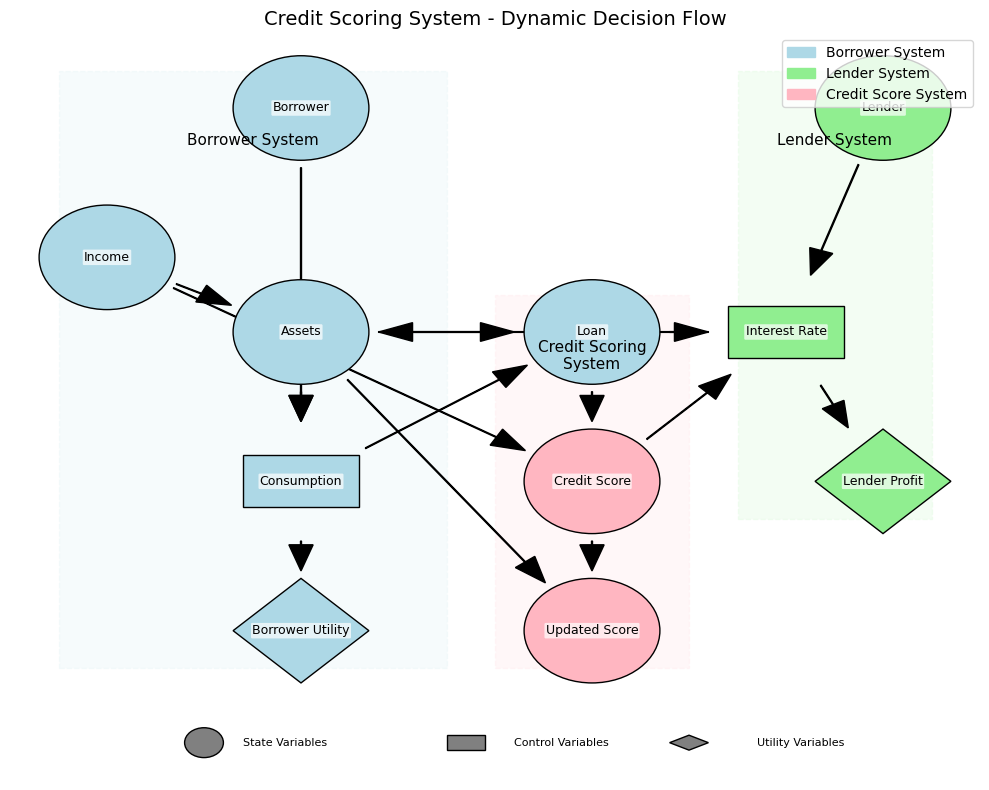

In [9]:
# Execute visualization
visualize_credit_model()

## How to set $R$

Let `R = Control(a, y)` be the rule for how money is lent.

This is a simple that avoids the state explosion of history.
But since `y` is autoregressive that's fine.

We can look at the dynamics with different rules.

### Todo: test with a couple variations of rules and plot the outcomes.

In [39]:
sim = MonteCarloSimulator(  ### Use fm, blockified
    calibration,
    consumption_block,
    {
        "R": lambda a, y : 1.03,
        "c": lambda w: w,
    },
    {  # initial states
        "a": 1,
        "y": 1.0,
    },
    agent_count=3,
    T_sim=120,
)

sim.initialize_sim()
hist = sim.simulate()

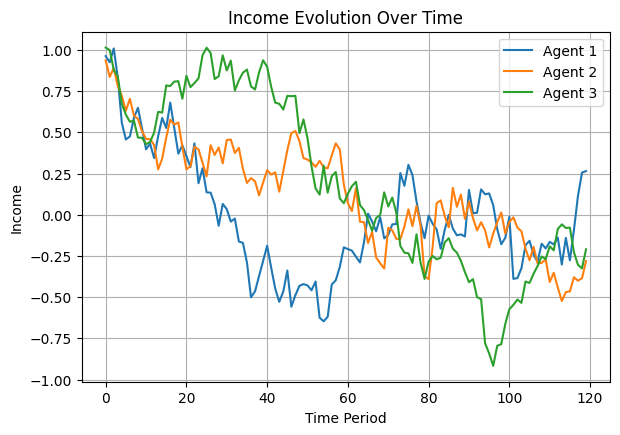

In [40]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(15, 10))


plt.subplot(2, 2, 2)
for agent in range(sim.agent_count):
    plt.plot(hist['y'][:, agent], label=f'Agent {agent+1}')
plt.title('Income Evolution Over Time')
plt.xlabel('Time Period')
plt.ylabel('Income')
plt.legend()
plt.grid(True)
plt.show()

### Implement value backup on the two rewards, see if it reaches a steady state.

In [7]:
f = lambda a, b, c, d: a + b - c * d

In [8]:
args = {
    'a' : 1,
    'b': 2,
    'c' : 3,
    'd' : 4,
    'e' : 5
}

In [9]:
f(*args)

TypeError: <lambda>() takes 4 positional arguments but 5 were given